# Image Process and Feature Matching

Dataset in use: https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset/data

In [1]:
import os
import cv2
import glob
import random
import pickle
import logging
import numpy as np
from tqdm import tqdm
from sklearn import metrics
from skimage import feature
from sklearn.svm import SVC 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def metric_report(actual, predicted):
    acc = metrics.accuracy_score(actual, predicted)
    precision = metrics.precision_score(actual, predicted)
    recall = metrics.recall_score(actual, predicted)
    f1 = metrics.f1_score(actual, predicted)    
    return (acc, precision, recall, f1)

In [4]:
ext='jpg'

In [5]:
def image_reader(file_path, in_use, ext=ext):
    
    images = []
    
    files = os.listdir(file_path)
    random.shuffle(files)

    files = files[:int(len(files)*in_use)]
    
    for file in tqdm(files, desc = 'Reading Images'):
        if file.endswith(ext):
            img_path = os.path.join(file_path, file)
            img = cv2.imread(img_path, 0)
            images.append(img)
            
    return images

In [6]:
'''

male_dir = './dataset/Training/male'
female_dir = './dataset/Training/female'

male_test_dir = './dataset/Validation/male'
female_test_dir = './dataset/Validation/female'

'''

"\n\nmale_dir = './dataset/Training/male'\nfemale_dir = './dataset/Training/female'\n\nmale_test_dir = './dataset/Validation/male'\nfemale_test_dir = './dataset/Validation/female'\n\n"

In [7]:
'''

train_male_images = image_reader(male_dir, 0.25)
train_female_images = image_reader(female_dir, 0.25)

'''

'\n\ntrain_male_images = image_reader(male_dir, 0.25)\ntrain_female_images = image_reader(female_dir, 0.25)\n\n'

In [8]:
'''

test_male_images = image_reader(male_test_dir, 0.1)
test_female_images = image_reader(female_test_dir, 0.1)

'''

'\n\ntest_male_images = image_reader(male_test_dir, 0.1)\ntest_female_images = image_reader(female_test_dir, 0.1)\n\n'

## Local Binary Patterns

In [9]:
class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
        self.numPoints = numPoints
        self.radius = radius

    def describe(self, image, eps=1e-7):
        lbp = feature.local_binary_pattern(image, self.numPoints, self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(),
                                 bins=np.arange(0, self.numPoints + 3),
                                 range=(0, self.numPoints + 2))
        
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        return hist

In [10]:
def single_image_pipeline(img, desc, male_hist_path, female_hist_path):
    
    lbp_hist = desc.describe(img)
    lbp_hist = lbp_hist.astype(np.float32)

    male_lbp_hist = np.load(male_hist_path).astype(np.float32)
    female_lbp_hist = np.load(female_hist_path).astype(np.float32)

    male_distance = cv2.compareHist(lbp_hist, male_lbp_hist, cv2.HISTCMP_CORREL)
    female_distance = cv2.compareHist(lbp_hist, female_lbp_hist, cv2.HISTCMP_CORREL)    
    # HISTCMP_INTERSECT, HISTCMP_CORREL, HISTCMP_BHATTACHARYYA, HISTCMP_HELLINGER, HISTCMP_CHISQR 
    
    return 0 if male_distance >= female_distance else 1 

In [11]:
desc = LocalBinaryPatterns(20, 5)

In [12]:
'''
Male-Female LBP histogramlari elde edilir ve kaydedilir. 
'''

'''
male_histograms = [desc.describe(img) for img in tqdm(train_male_images, desc="Computing LBP histogram - Male")]
female_histograms = [desc.describe(img) for img in tqdm(train_female_images, desc="Computing LBP histogram - Female")]

np.save('male_lbp_histograms.npy', male_histograms)
np.save('female_lbp_histograms.npy', female_histograms)

male_lbp_hist = np.mean(male_histograms, axis=0)
female_lbp_hist = np.mean(female_histograms, axis=0)

np.save('male_lbp_hist.npy', male_lbp_hist)
np.save('female_lbp_hist.npy', female_lbp_hist)
'''

'\nmale_histograms = [desc.describe(img) for img in tqdm(train_male_images, desc="Computing LBP histogram - Male")]\nfemale_histograms = [desc.describe(img) for img in tqdm(train_female_images, desc="Computing LBP histogram - Female")]\n\nnp.save(\'male_lbp_histograms.npy\', male_histograms)\nnp.save(\'female_lbp_histograms.npy\', female_histograms)\n\nmale_lbp_hist = np.mean(male_histograms, axis=0)\nfemale_lbp_hist = np.mean(female_histograms, axis=0)\n\nnp.save(\'male_lbp_hist.npy\', male_lbp_hist)\nnp.save(\'female_lbp_hist.npy\', female_lbp_hist)\n'

In [13]:
# predictions_male = []
# for img in test_male_images:
#     predictions_male.append(single_image_pipeline(img, desc, 'male_lbp_hist.npy', 'female_lbp_hist.npy'))

In [14]:
# predictions_female = []
# for img in test_female_images:
#     predictions_female.append(single_image_pipeline(img, desc, 'male_lbp_hist.npy', 'female_lbp_hist.npy'))

In [15]:
# actual = np.hstack( (np.zeros(len(predictions_male)), np.ones(len(predictions_female))))
# predicted = np.hstack( (predictions_male, predictions_female) )

In [16]:
# metric_report(actual, predicted)

In [17]:
# confusion_matrix = metrics.confusion_matrix(actual, predicted)

In [18]:
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Male', 'Female'])
# cm_display.plot()
# plt.show()

## Inference of LBP

In [19]:
# Asagidaki img_path degiskenine istenen goruntulerin pathi verilir ve lbp ile gender detect edilir.

img_path = './test_images/064943.jpg.jpg'
img = cv2.imread(img_path, 0)
actual = int(os.path.basename(img_path).startswith('1'))

pred = single_image_pipeline(img, desc, 'male_lbp_hist.npy', 'female_lbp_hist.npy')

if actual == pred:
        print('Gender Detected!', '\ngender is', 'female' if actual else 'male')

Gender Detected! 
gender is male


In [20]:
img_path = 'arda.jpg' 
img = cv2.imread(img_path, 0)
actual = 0

pred = single_image_pipeline(img, desc, 'male_lbp_hist.npy', 'female_lbp_hist.npy')

if actual == pred:
    print('Gender Detected!', '\ngender is', 'female' if actual else 'male')

Gender Detected! 
gender is male


## Histogram of Oriented Gradients (HoG)

In [21]:
hog = cv2.HOGDescriptor()

In [22]:
def pca_dim_reductor(train, test, num_component):
    pca =PCA(n_components=self.component)
    pca.fit(train)
    pcaTrain = pca.fit_transform(train)
    pcaTest = pca.transform(test)
    print("original shape of data:   ", train.shape)
    print("transformed shape of data:", pcaTrain.shape)
    return pcaTrain, pcaTest

In [23]:
def hog_pattern_extractor(hog: cv2.HOGDescriptor, images, ext=ext, r_shape=(64, 128)):
    data = []
    
    for img in tqdm(images):
        img_resized = cv2.resize(img, r_shape)
        
        hist = hog.compute(img_resized)
        hist = hist.flatten()
        
        data.append(hist)
    
    return data

In [24]:
def single_image_pipeline_hog(img, hog, male_hist_path, female_hist_path, r_shape=(64, 128)):
    
    img_resized = cv2.resize(img, r_shape)
    hist = hog.compute(img_resized)
    hist = hist.astype(np.float32)

    male_hog_hist = np.load(male_hist_path).astype(np.float32)
    female_hog_hist = np.load(female_hist_path).astype(np.float32)

    male_distance = cv2.compareHist(hist, male_hog_hist, cv2.HISTCMP_INTERSECT)
    female_distance = cv2.compareHist(hist, female_hog_hist, cv2.HISTCMP_INTERSECT)    
    # HISTCMP_INTERSECT, HISTCMP_CORREL, HISTCMP_BHATTACHARYYA, HISTCMP_HELLINGER, HISTCMP_CHISQR 
    
    return 0 if male_distance >= female_distance else 1 

In [23]:
# male_histograms =  hog_pattern_extractor(hog, train_male_images)
# female_histograms = hog_pattern_extractor(hog, train_female_images)

# male_hog_hist = np.mean(male_histograms, axis=0)
# female_hog_hist = np.mean(female_histograms, axis=0)

# np.save('male_hog_hist.npy', male_hog_hist)
# np.save('female_hog_hist.npy', female_hog_hist)

100%|██████████████████████████████████████████████████████████████████| 5810/5810 [00:01<00:00, 4270.13it/s]


In [24]:
# actual, predicted = [], []

# for img in test_male_images:
#     actual.append(0)
#     predicted.append(single_image_pipeline_hog(img, hog, 'male_hog_hist.npy', 'female_hog_hist.npy'))

In [25]:
# for img in test_female_images:
#     actual.append(1)
#     predicted.append(single_image_pipeline_hog(img, hog, 'male_hog_hist.npy', 'female_hog_hist.npy'))

In [26]:
# metric_report(actual, predicted)

(0.7079037800687286,
 0.9236111111111112,
 0.4554794520547945,
 0.6100917431192661)

In [27]:
# confusion_matrix = metrics.confusion_matrix(actual, predicted)

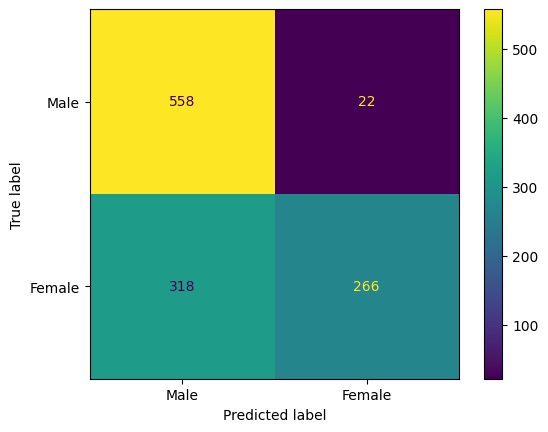

In [28]:
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Male', 'Female'])
# cm_display.plot()
# plt.show()

## Inference of HOG

In [19]:
# Asagidaki img_path degiskenine istenen goruntulerin pathi verilir ve hog ile gender detect edilir.

img_path = './test_images/064943.jpg.jpg'
img = cv2.imread(img_path, 0)
actual = int(os.path.basename(img_path).startswith('1'))

pred = single_image_pipeline_hog(img, hog, 'male_hog_hist.npy', 'female_hog_hist.npy')

if actual == pred:
    print('Gender Detected!', '\ngender is', 'female' if actual else 'male')

Gender Detected! 
gender is male


In [30]:
img_path = 'arda.jpg'; actual = 0 

In [32]:
img_path = 'harun.jpg'; actual = 0

In [34]:
img_path = './test_images/114234.jpg.jpg'; actual = 1

In [35]:
img = cv2.imread(img_path, 0)


pred = single_image_pipeline_hog(img, hog, 'male_hog_hist.npy', 'female_hog_hist.npy')

if actual == pred:
    print('Gender Detected!', '\ngender is', 'female' if actual else 'male')

Gender Detected! 
gender is female
